# Figure 2 - Background variation

In [1]:
# load external dependencies
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation

# load internal dependencies
import colors,plot,stats,utils
from paths import *

%load_ext autoreload
%autoreload 2

## Data import

In [224]:
files = glob.glob(dir_data+"seq/filterHD-v1.0/seg_sites/pools/SNVs.seg.WAxNA_F12_1_RM_1.filtered.posterior-*.txt")

seq_freq_df = pd.DataFrame()
for pp in files:
    # read into pandas dataframe
    frame = pd.read_csv(pp, sep=r"\s+", index_col=None)
    frame.rename(columns={'#sample': 'chr_arabic'}, inplace=True)
    #
    f = re.split(r'[.-]+', os.path.basename(pp))
    frame['sample'] = f[2]
    frame['background'] = f[2].split('_')[0]
    frame['cross'] = f[2].split('_')[1]
    frame['cross_rep'] = f[2].split('_')[2]
    frame['env'] = f[2].split('_')[3]
    frame['prop_rep'] = f[2].split('_')[4]
    frame['time'] = int(f[5])
    #
    seq_freq_df = seq_freq_df.append(frame, ignore_index=True)
    

seq_freq_df = utils.chr_to_gw(seq_freq_df)

# convert coordinates to kb
seq_freq_df['site'] /= 1E3

seq_freq_df = pd.pivot_table(seq_freq_df, index=['sample','chr_arabic','site'], columns=['time'], values='mean')

seq_freq_df.head()

time                                  2      4      8      16     32
sample           chr_arabic site                                    
WAxNA_F12_1_RM_1 1          2.718  0.951  0.929  0.951  0.942  0.966
                            2.731  0.952  0.929  0.952  0.942  0.967
                            2.734  0.952  0.929  0.952  0.942  0.967
                            4.532  0.958  0.936  0.952  0.935  0.973
                            5.035  0.959  0.936  0.941  0.936  0.979

Bottom panel

In [223]:
# load data
files = glob.glob(dir_data+'seq/QTL-figure-1.0-data/WAxNA*kb*.txt')

seq_qtl_df = pd.DataFrame()

for fn in files:
    # read into pandas dataframe
    df = pd.read_csv(fn, sep=r"\s+", names=['locus','score'], index_col=None)
    df.rename(columns={'#sample': 'chr'}, inplace=True)
    #
    f = re.split(r'[.-]+', os.path.basename(fn))
    df['environment'] = f[0].split('_')[3]
    df['sample'] = f[0]
    df['chr'] = f[2].replace('chr','')
    df['resolution'] = float(f[3].replace('kb',''))
    #
    seq_qtl_df = seq_qtl_df.append(df, ignore_index=True)

# convert coordinates to kb
seq_qtl_df['locus'] /= 1E3

# 
seq_qtl_df = pd.pivot_table(seq_qtl_df, index=['chr','locus'], columns=['resolution','environment','sample'], values='score')

# reorder columns
seq_qtl_df = seq_qtl_df.reindex(columns=['HU','RM','MO'], level='environment')

# drop the population label
seq_qtl_df.columns = seq_qtl_df.columns.droplevel(level=['sample'])

seq_qtl_df.head()

resolution         2                                                           \
environment        HU       HU        HU       HU        HU       HU       RM   
chr locus                                                                       
12  15.424   0.096706  70.4832  0.020368  35.6058  0.021972  4.12386  4.68143   
    15.466   0.065370  69.1842  0.173942  34.8159  0.060021  4.31458  3.64655   
    15.467   0.065365  69.1842  0.173890  34.8159  0.060019  4.31458  3.64655   
    15.487   0.065398  69.1842  0.173893  34.8159  0.060034  4.31457  3.64652   
    15.654   0.038136  66.4977  0.296083  34.7954  0.101564  4.39088  2.79018   

resolution                                 ...          50                     \
environment       RM        RM       RM    ...          RM        RM       RM   
chr locus                                  ...                                  
12  15.424   7.54274  0.218540  12.3925    ...     3.54773  0.011633  4.32386   
    15.466   7.13699  0.355271  11.6841    ...     3.54775  0.011775  4.32725   
    15.467   7.13698  0.355259  11.6840    ...     3.54777  0.011728  4.32722   
    15.487   7.13700  0.355268  11.6840    ...     3.54773  0.011736  4.32724   
    15.654   6.76814  0.374136  12.2202    ...     3.64734  0.005185  4.27407   

resolution                                                                   
environment       RM       RM       MO       MO       MO       MO        MO  
chr locus                                                                    
12  15.424   6.62446  4.72040  7.27918  17.7591  11.2339  1.66231  0.051538  
    15.466   6.62446  4.72045  7.24651  17.7591  11.2339  1.66697  0.051551  
    15.467   6.62448  4.72054  7.24647  17.7590  11.2339  1.66693  0.051549  
    15.487   6.62453  4.72052  7.24633  17.7591  11.2339  1.66696  0.051539  
    15.654   6.62686  4.77403  7.18921  17.9820  11.6320  1.72610  0.055708  

[5 rows x 105 columns]

In [83]:
# x=seq_qtl_df.loc['8',(30,['HU','RM','MO'])]
# x.columns=x.columns.droplevel('sample')#.plot(legend=False)
# x.plot(legend=False)

In [227]:
# load data
files = glob.glob(dir_data+'seq/QTL-figure-1.0-data/bestScores.*')

seq_scores_df = pd.DataFrame()

for fn in files:
    # read into pandas dataframe
    df = pd.read_csv(fn, sep=r"\s+", names=['locus','score'], index_col=None)
    df.rename(columns={'#sample': 'chr'}, inplace=True)
    #
    f = re.split(r'[.-]+', os.path.basename(fn))
    df['environment'] = f[1]
    df['chr'] = f[2].replace('chr','')
    df['resolution'] = float(f[3].replace('kb',''))
    #
    seq_scores_df = seq_scores_df.append(df, ignore_index=True)

# seq_scores_df = pd.pivot_table(seq_scores_df, index=['env','chr','locus'], columns=['resolution'], values='score')

seq_scores_df['locus'] /= 1E3

# # load data
# files = glob.glob(dir_data+'data.main.text.figures/QTL-figure-1.0-data/bestScores.HU.chr12.kb30.0.txt')

# seq_qtl_best_df = pd.read_csv(files[0], sep='\t')
seq_scores_df.head()

,locus,score,environment,chr,resolution
0,650.632,589.61400,HU,12,10
1,640.928,3.24466,HU,12,10
2,640.928,302.15000,HU,12,10
3,640.928,245.66600,HU,12,10
4,650.274,110.43300,HU,12,10


In [5]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/pheno_populations_norm.pickle')

pheno_df = pheno_df.replace('WAxNA','WA/NA')

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.env_test.isin([u'RM'])) &\
                    ((pheno_df.population == u'WA/NA') & (pheno_df.genotype_long == u'WT'))|\
                    ((pheno_df.population == u'WA/NA') &(pheno_df.gene.isin([u'CTF8',u'KOG1'])))]

pheno_df['genotype_long'] = pheno_df['genotype_long'].replace('CTF8','',regex=True)
pheno_df['genotype_long'] = pheno_df['genotype_long'].replace('ctf8','',regex=True)
pheno_df['genotype_long'] = pheno_df['genotype_long'].replace('KOG1','',regex=True)
pheno_df['genotype_long'] = pheno_df['genotype_long'].replace('kog1','',regex=True)
pheno_df['genotype_long'] = pheno_df['genotype_long'].replace(' ','',regex=True)

pheno_df.head()

,env_evo,env_test,run,Index,Plate,Row,Column,ID,ID_plate,background,...,assignment,isolate,gene,genotype_short,genotype_long,aminoacid,mating,auxotrophy,doubling_time,growth_rate
450,RM,RM,1,450,0,9,18,P10_C5,10,parents,...,,,,,WT,,MATa/α,,0.454481,0.729773
454,RM,RM,1,454,0,9,22,P10_C6,10,parents,...,,,,,WT,,MATa/α,,0.361519,0.778345
546,RM,RM,1,546,0,11,18,P10_C5,10,parents,...,,,,,WT,,MATa/α,,0.389962,0.763150
550,RM,RM,1,550,0,11,22,P10_C6,10,parents,...,,,,,WT,,MATa/α,,0.440472,0.736894
1010,RM,RM,1,1010,0,21,2,P10_F1,10,constructs,...,,,KOG1,,ΔWA/NA,,MATa/α,,NaN,NaN


In calculating the log-likelihood score, shown below, we see the coefficients of each county's non-hierarchical posterior mean (blue) and the hierarchical posterior mean (red). To show the effect of selection on a single coefficient-pair (alpha and beta) we connect the blue and red points belonging to the same county by an arrow. Some non-hierarchical posteriors are so far out that we couldn't display them in this plot (it makes the axes too wide). Interestingly, all hierarchical posteriors of the floor-measure seem to be around -0.6 indicating that having a basement in almost all county's is a clear indicator for heightened radon levels. The intercept (which we take for type of soil) appears to differ among countys. This information would have been difficult to find if we had only used the non-hierarchial model.

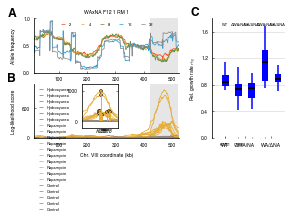

In [230]:
# environment attributes
environments = {u'HU': u'Hydroxyurea', 
                u'RM': u'Rapamycin', 
                u'MO': u'Control'}

dict_environment = {
    'color':{
        'HU':colors.fte_colors[1],
        'RM':colors.fte_colors[2],
        'MO':colors.fte_colors[4] 
    }
}
dict_time = {
    'color': {
        2:colors.fte_colors[1],
        4:colors.fte_colors[2],
        8:colors.fte_colors[3],
        16:colors.fte_colors[0],
        32:colors.fte_colors[4]
    },
    'linewidth': {
        2:0.75,4:0.75,8:0.75,16:0.75,32:0.75
    },
    'style': {
        2:'-',4:'-',8:'-',16:'-',32:'-'  
    }
}

fig = plt.figure(figsize=(4, 2), dpi=300)

import matplotlib.gridspec as gridspec
grid = gridspec.GridSpec(2, 2, width_ratios=[2,1], height_ratios=[1,1], hspace=0.2, wspace=0.3)

gs = {}
gs['freq'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['llh'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,0])
gs['pheno'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[:,1])

### top panel ###
ax1 = plt.subplot(gs['freq'][:])

utils.simple_axes(ax1)

for ax in [ax1]:
    freq = seq_freq_df.loc[('WAxNA_F12_1_RM_1',8),:]
    
    for col in freq.columns:
        freq[col].plot(ax=ax,
                       color=dict_time['color'][col],
                       lw=dict_time['linewidth'][col],
                       style=dict_time['style'][col],
                       legend=False)

ax1.set_ylabel('Allele frequency')# $q_i^\\mathrm{WA}$')

for ax in [ax1]:
    ax.set_ylim(0,1)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
    
ax1.set_title('WAxNA F12 1 RM 1', fontsize=5)

# shaded region
ax1.axvspan(4.2E2, 5.2E2, color='0.9', lw=0)

ax1.legend(frameon=False, prop={'size':4}, ncol=5,
           loc='upper center', handlelength=1.5)

### bottom panel ###
ax2 = plt.subplot(gs['llh'][:], sharex=ax1)
ax2_zoom = inset_axes(ax2, 0.5, 0.6, loc=1, 
                      bbox_to_anchor=(0.4,0.5), 
                      bbox_transform=ax2.figure.transFigure)

utils.simple_axes(ax2)

for ax in [ax2,ax2_zoom]:
    # slice chr. VII at 30 kb resolution
    llh = seq_qtl_df.loc['8',30]
    llh.rename(columns=environments).plot(ax=ax, 
                                          color=[dict_environment['color'][e] for e in llh.columns.get_level_values('environment')],
                                          lw=0.75, legend=False)

for environment, score in seq_scores_df[(seq_scores_df.resolution==30)].groupby('environment'):
    markerline, stemlines, baseline = ax2_zoom.stem(score.locus, score.score)
    
    plt.setp(stemlines, linewidth=1, color=dict_environment['color'][environment],
             path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="k")])  
    plt.setp(markerline, 'color', dict_environment['color'][environment], markersize = 3)
    plt.setp(markerline, 'markerfacecolor', dict_environment['color'][environment], markersize = 3)
    plt.setp(baseline, 'color', 'none')


# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
# mark_inset(ax2, ax2_zoom, loc1=1, loc2=3, alpha=0.5, fc="gray", ec="none")

ax2.set_xlabel('Chr. VIII coordinate (kb)')
ax2.set_ylabel('Log-likelihood score')

# shaded region
ax2.axvspan(4.2E2, 5.2E2, color='0.9', lw=0)

# axes limits
for ax in [ax2]:
    ax.set_ylim(0, 1.1E3)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
for ax in [ax2_zoom]:
    ax.set_xlabel('')
    ax.set_xlim(4.2E2, 5.2E2)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))

# ax2.set_xlim(0, 6E5)
# ax2_zoom.set_xlim(4.2E5, 5E5)
# plot.zoom_effect(ax2, ax1_zoom, 4.2E5, 5E5, edgecolor='black', facecolor='gray')#, edgewidth=5)

trans = ax2_zoom.get_xaxis_transform() # x in data units, y in axes fraction

for gene, loc in zip(['CTF8','KOG1'],[486.230+(486.631-486.230)/2.,475.999+(480.672-475.999)/2.]):
    ax2.annotate(gene, xy=(loc, -0.05),
                 xytext=(0, -3), textcoords='offset points',
                 arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                 xycoords=trans, fontsize=5, style='italic', va='bottom', ha='center')    
    
# ax2.legend(frameon=False, prop={'size':4},
#            loc='center left', borderaxespad=0.,
#            handlelength=0.75, title='Time')#bbox_to_anchor=(1.05, 0.5), 

lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, frameon=False, prop={'size':4},
           loc='upper left', handlelength=1.5)  # legend for first two lines only

### right-hand panel ###
ax3 = plt.subplot(gs['pheno'][:])

param = 'growth_rate'

p = pheno_df.set_index(['population','gene','genotype_long'], append=True)[param]\
.unstack(['population','gene','genotype_long'])

ax3, bp = p.plot(ax=ax3, kind='box', return_type='both',
                 labels=p.columns.get_level_values('population'))

plot.boxplot_custom(bp, ax3, ['b']*10, ['']*10)
#                colors=[color_background_mut[b] for b in gph3.columns.get_level_values('population')],
#                            hatches=['']*30)

## background
xlabels = p.columns.get_level_values('genotype_long')
for v, k in enumerate(xlabels):
    ax3.annotate('\nx\n'.join(k) if isinstance(k, tuple) else k, 
                 xy=(v+1, 0.97), xycoords=("data", "axes fraction"),
                 ha='center', va='top', annotation_clip=False, fontsize=4)

# for line in bp['whiskers']:
#     x, y = line.get_xydata()[1] # bottom of left line
#     ax3.text(x, y, '%.1f' % x,
#          horizontalalignment='center', # centered
#          verticalalignment='top')      # below
#     x, y = line.get_xydata()[3] # bottom of right line
#     ax3.text(x,y, '%.1f' % x,
#          horizontalalignment='center', # centered
#              verticalalignment='top')      # below

xlabels = p.columns.get_level_values('genotype_long')
ax3.set_xticks([x for x in np.arange(len(xlabels))], minor=True)
ax3.set_xticklabels(['/'.join(x) if isinstance(x, tuple) else x for x in xlabels], fontsize=4)

# gene
xstart, xend, xlabels = plot.set_custom_labels(p.columns, 1)
ax3.set_xticks([x+1 for x in xlabels.values()], minor=False)
ax3.set_xticklabels(xlabels.keys(), minor=True, fontsize=6)

ax3.set_ylabel(r'Rel. growth rate $r_{bg}$', fontsize=6)

ax3.set_ylim(0,1.8)

ax3.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax1.text(-0.125, 1.2, 'A', transform=ax1.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')
ax2.text(-0.125, 1.2, 'B', transform=ax2.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')
ax3.text(-0.175, 1.1, 'C', transform=ax3.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')

ax1.get_yaxis().set_label_coords(-0.125,0.5)
ax2.get_yaxis().set_label_coords(-0.125,0.5)
ax3.get_yaxis().set_label_coords(-0.175,0.5)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(5)
    ax.yaxis.label.set_size(5)
    ax.tick_params(axis='both', which='major', size=2, labelsize=5)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    for sp in ax.spines.values():
        sp.set(color='k', linewidth=0.75, linestyle='-')

fig.savefig(dir_paper+'figures/figure2/figure2.svg', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure2/figure2.png', dpi=300, bbox_inches='tight')
plt.show()

In [184]:
# for ax in [ax2,ax2_zoom]:
  
#     for k, s in seq_qtl_df.loc['8'].groupby(axis=1,level='environment'):
        
#         s.loc[:,(k,30)].plot(ax=ax,
#                              color=dict_environment['color'][k],
#                              lw=0.75, label=k,
# #                       lw=dict_time['linewidth'][col],
# #                       style=dict_time['style'][col],
# #                       extent=[4.2E5, 5E5, 0, 1E3],
#                          legend=False)


#         print seq_qtl_df.loc[(s,'8')].shape
#         s.loc[(s,'8'),30].plot(ax=ax, legend=False)
#     for s in seq_qtl_df.index.get_level_values('sample').unique():
# #         print seq_qtl_df.loc[(s,'8')].shape
#         seq_qtl_df.loc[(s,'8'),30].plot(ax=ax,
#                                         legend=False)

#     for col in llh.columns:
#         llh[col[0]].plot(ax=ax,
#                          color=dict_environment['color'][col[0]],
#                          lw=0.75, label=col[0],
# #                       lw=dict_time['linewidth'][col],
# #                       style=dict_time['style'][col],
# #                       extent=[4.2E5, 5E5, 0, 1E3],
#                          legend=False)
        
# ax2_zoom.axis([4.2E5, 5E5, 0, 1E3])
        
#     llh.plot(ax=ax, color=[dict_environment[c] for c in llh.columns], lw=1, legend=False)

In [104]:
# llh = seq_qtl_df.loc['8',(['HU','RM','MO'],30)]
# # llh.columns = llh.columns.droplevel(level=['sample','resolution'])

# llh = llh.rename(index=environments)

# for ax in [ax2,ax2_zoom]:

#     for col in llh.columns:
#         llh[col[0]].plot(ax=ax,
#                          color=dict_environment['color'][col[0]],
#                          lw=0.75, label=col[0],
# #                       lw=dict_time['linewidth'][col],
# #                       style=dict_time['style'][col],
# #                       extent=[4.2E5, 5E5, 0, 1E3],
#                          legend=False)



In [50]:
# llh['RM'].plot(legend=False)#lines[:3], llh.columns.unique(),

In [47]:
for col in llh.columns:
    print col[0]

HU
HU
HU
HU
HU
HU
MO
MO
MO
MO
MO
RM
RM
RM
RM
RM
RM
RM
RM
RM
RM


In [185]:
# import pylab as pl
# import numpy as np
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# x=np.linspace(0,1,100)
# y=x**2

# ax=pl.subplot(1,1,1)
# ax.plot(x,y)

# # axins = zoomed_inset_axes(ax, 1, loc=2,bbox_to_anchor=(0.2, 0.55),bbox_transform=ax.figure.transFigure) # zoom = 6
# axins = inset_axes(ax, 1,1 , loc=2,bbox_to_anchor=(0.2, 0.55),bbox_transform=ax.figure.transFigure) # no zoom



# axins.plot(x,y)

# x1, x2= .4, .6
# y1,y2 = x1**2,x2**2
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
# pl.show()

In [ ]:
# ax1.set_xlim(0, 6E5)
# ax1_zoom.set_xlim(4.2E5, 5E5)
# ax1_zoom.set_ylim(0, 1)
# plot.zoom_effect(ax1, ax2, 4.2E5, 5E5, color='gray')

# trans = ax1.get_xaxis_transform() # x in data units, y in axes fraction

# ax1.annotate('WAxNA F12 1 RM 1', xy=(0.5, 1.05),
#              xytext=(0, 3), textcoords='offset points',
#              fontsize=5, style='italic', va='bottom', ha='center')